In [2]:
import torch
from sentence_transformers import SentenceTransformer, util
import numpy as np
# graph the vectors and their cosine similarities
import matplotlib.pyplot as plt
import networkx as nx
import chunkPDF as chunk


In [3]:
pdir = "ExampleRFPs/"
pdf_names = [
    'GoodFit/IETSS DRAFT PWS v2 for RFI FINAL to POST.pdf', # 100% works fine, no issues
    'GoodFit/Attachment A - Statement of Work_July 2023.pdf', # does not work, different newlines formatting issue
    'GoodFitWithPartners/2024_11_15_R_G1ab8GqBwjXy42h_1.pdf', # Fails to split Background section correctly, rest is fine
    'GoodFitWithPartners/2.2.1 Attachment 1 GMMAD BPA PWS 112724.1732744126731.pdf', # some malformed text but overall good parsing
    'BadFit/Draft_Retirement_Services_COBOL_Database_Modernization_PWS.pdf', # <-- This doc is driving me nuts, there is no logical text breaks between  numbered sections
    'GoodFit/RFP+CR-346570+Attachment+A+SOW+SQA+Consulting.pdf', # 100% works fine, no issues
    'GoodFitWithPartners/FPAC Conservation Agile Release Train PWS.1729019986846.pdf', # fails to split most subsections correctly.
    'GoodFitWithPartners/CB24-RFQ0009 IT Project Manager.pdf', #this has checkboxes causing malformed text issues
    'GoodFitWithPartners/Request for Quotation.pdf', #ok
    'BadFit/DRAFT Performance Work Statement VA.1732132924898.pdf' #ok
    
    ]

In [4]:
# Use chunkPDF to extract paragraphs from the PDF
paragraphs = chunk.process_pdf( pdir + pdf_names[6])


if not paragraphs:
    raise ValueError("No valid paragraphs found in the PDF content.")

for i, para in enumerate(paragraphs):  
    print(f"section {i+1}:\n{para}\n")

section 1:
United States Department of Agriculture

section 2:
Farm Production and Conservation

section 3:
Conservation 
<Value Stream Name> 
Agile Release Train 
Performance Work Statement

section 4:
PWS Version 0.2 
updated: 10/14/2024 

Revision History 
Date Version Description Author 
07/31/2024 0.1 Initial Draft Kara Cochran 
10/1/2024 – 10/14/2024 0.2 Incorporate edits and comments from 
integrated acquisition planning team 
Cavine Phillips 
Kara Cochran

section 5:
Table of Contents 
1 Background ........................................................................................................................................................ 6 
1.1 Farm Production and Conservation Mission Area ................................................................................... 6 
1.2 NRCS Organization and Vision ................................................................................................................. 6 
1.2.1 NRCS Programs .........................

In [16]:
# save the list of paragraphs as a json file
import json
with open('paragraphs.json', 'w') as f:
    json.dump(paragraphs, f)

In [5]:
format_queries = [
    "Identify sections where a statement introduces a list of bullet points.",
    "Find paragraphs that are semantically related but separated, such as a heading and its corresponding content.",
    "Locate sections where a summary or introductory statement is followed by detailed points or examples.",
    "Group bullet points with their preceding explanatory paragraph.",
    "Identify disconnected sections that should logically be grouped together."
]

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
# Encode the paragraphs into embeddings.
doc_embeddings = model.encode(paragraphs)

In [8]:

# Iterate through paragraphs to find related chunks
related_sections = []
for i, para in enumerate(paragraphs):
    para_embedding = doc_embeddings[i]
    # Compute similarity with all other paragraphs
    similarities = util.cos_sim(para_embedding, doc_embeddings)
    # Find paragraphs with high similarity (e.g., above 0.8 threshold)
    related_indices = [j for j, score in enumerate(similarities[0]) if score > 0.7 and j != i and abs(i - j) < 3 ]  # Ensure they are close in index
    if related_indices:
        related_sections.append((i, related_indices))

# Output related sections
for main_idx, related_idxs in related_sections:
    print(f"Section {main_idx} is related to: {related_idxs}")

Section 7 is related to: [8]
Section 8 is related to: [7]
Section 16 is related to: [17]
Section 17 is related to: [16]
Section 50 is related to: [52]
Section 52 is related to: [50]
Section 59 is related to: [60]
Section 60 is related to: [59]
Section 62 is related to: [64]
Section 64 is related to: [62, 65]
Section 65 is related to: [64]
Section 76 is related to: [77]
Section 77 is related to: [76]
Section 79 is related to: [80]
Section 80 is related to: [79]
Section 100 is related to: [102]
Section 101 is related to: [102]
Section 102 is related to: [100, 101]
Section 104 is related to: [106]
Section 106 is related to: [104]
Section 115 is related to: [116, 117]
Section 116 is related to: [115, 117]
Section 117 is related to: [115, 116]
Section 118 is related to: [119, 120]
Section 119 is related to: [118, 120]
Section 120 is related to: [118, 119]
Section 121 is related to: [122]
Section 122 is related to: [121]
Section 128 is related to: [130]
Section 130 is related to: [128, 131, 

In [9]:
queries = [
    "which section is about the objective? Objectives normally provide context for the document's existence.",
    "which section is about the background? Background sections provide context or history relevant to the document's purpose.",
    "which section is about the work scope? The work scope outlines the boundaries of the project, including what is included and excluded from the work to be done.",
    "which section is about the deliverables? Deliverables are often lists of expected results.",
    "which section is about the performance metrics? Performance metrics define how the success of the work will be measured, including quality standards and evaluation criteria.",
]

This code generates a graph of the query similarity between the top 5 results as text embeddings.

Query: which section is about the objective? Objectives normally provide context for the document's existence.
Result 0:
Objectives 
Objectives summarize the business and technical goals that teams and trains intend to achieve in the upcoming 
PI and are either committed or uncommitted. The team should not include more than 2-3 uncommitted 
objectives, per PI.  
Committed objectives are those that the development team has high conﬁdence in delivering during the PI. 
Committed objectives are included in overall Business Value calculation.  
Uncommitted objectives are used to identify work that can be variable within the scope of a PI. The work is 
planned, but the outcome is not certain. Teams can apply uncommitted objectives whenever there is low 
conﬁdence in meeting the objective. This low conﬁdence can be due to many circumstances:  
Dependencies with another team or supplier that cannot be guaranteed.  
The team has little to no experience with functionality of this type.  
There a

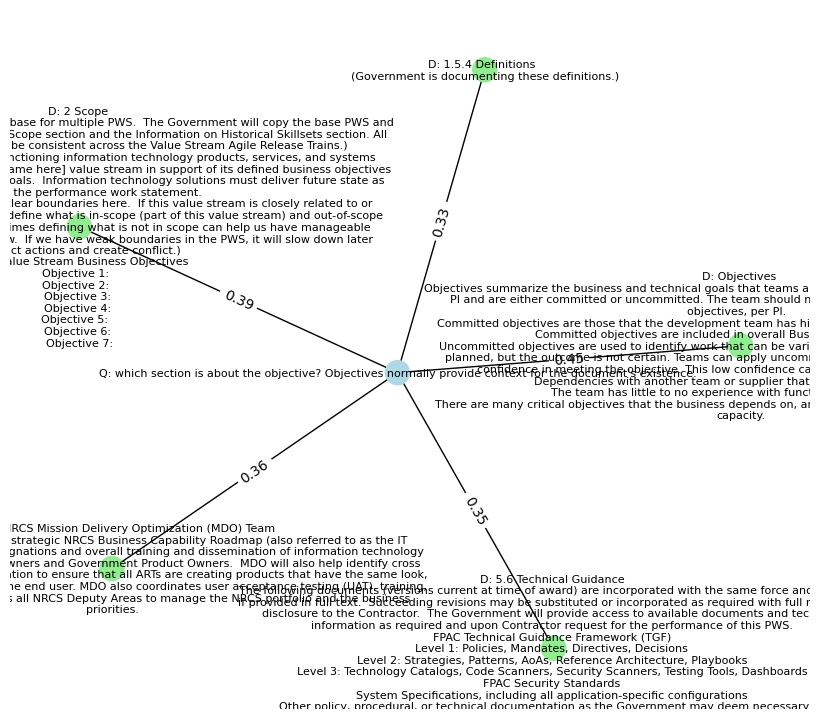

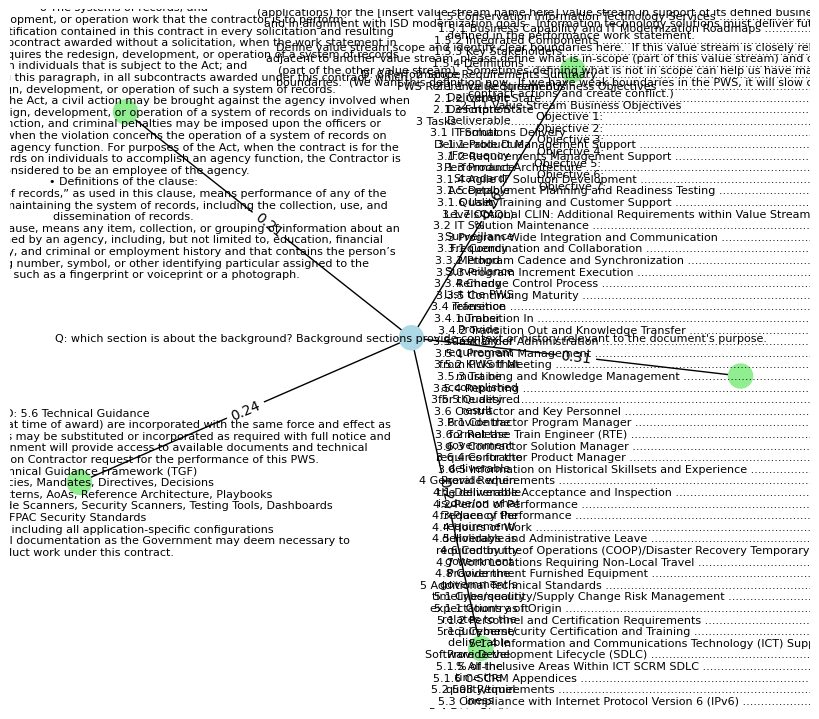

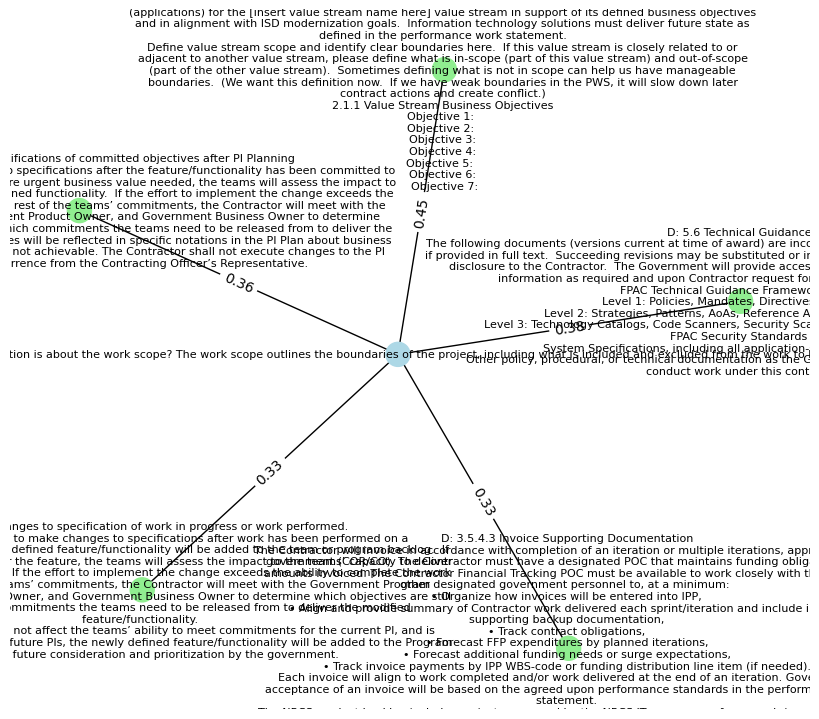

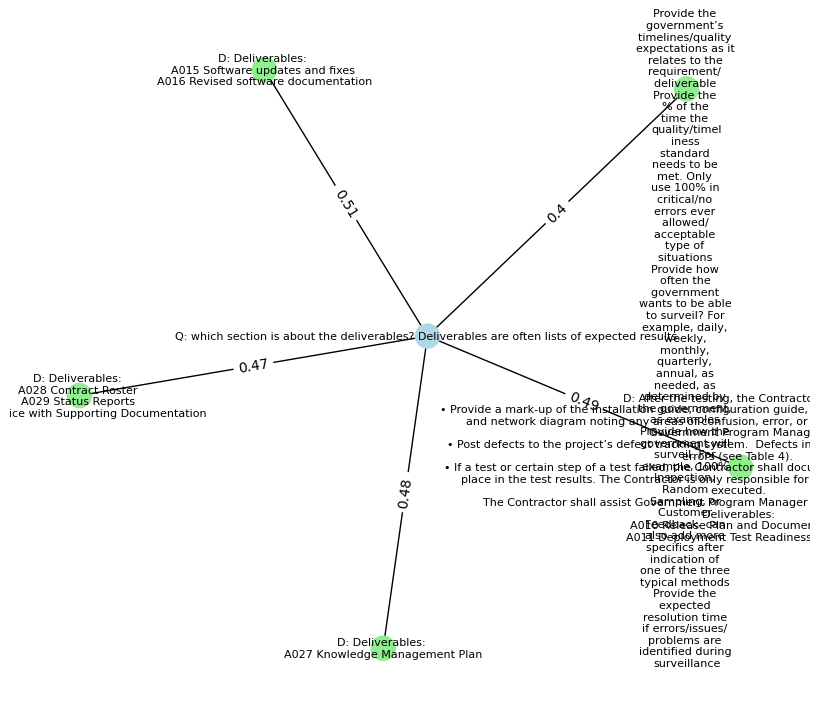

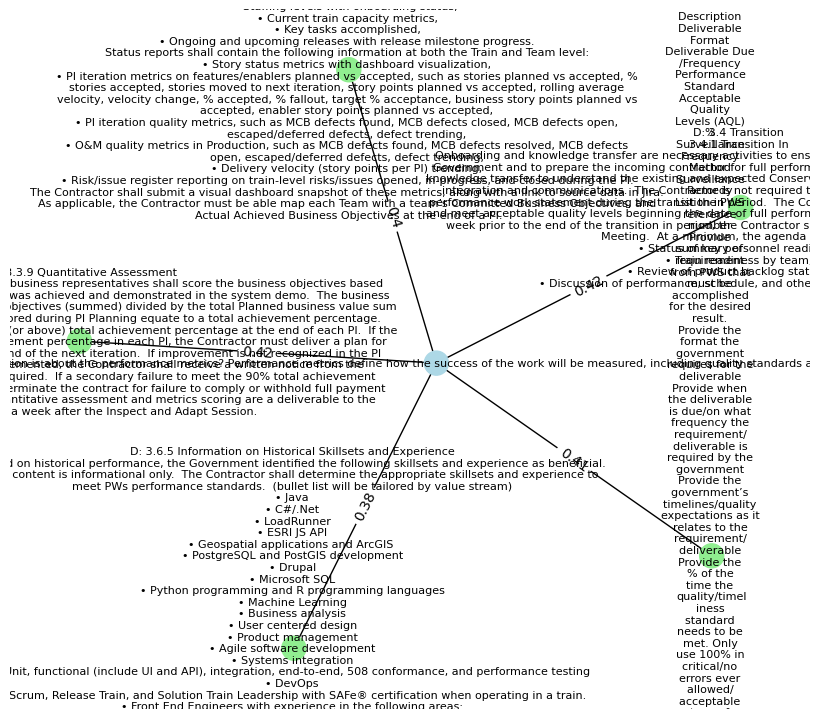

In [10]:

# Create a graph for top 5 results
for query in queries:
    G = nx.Graph()
    query_embedding = model.encode(query)
    # Compute cosine similarities
    cos_scores = model.similarity(query_embedding, doc_embeddings)[0]
    # Get top 5 results
    top_results = torch.topk(cos_scores, 5)
    # Add top results to graph
    for i in range(len(top_results[0])):
        G.add_node(f"Q: {query}", type='query')
        G.add_node(f"D: {paragraphs[top_results[1][i]]}", type='doc')
        G.add_edge(f"Q: {query}", f"D: {paragraphs[top_results[1][i]]}", weight=top_results[0][i].item())
        print(f"Query: {query}\nResult {i}:\n{paragraphs[top_results[1][i]]}\nScore: {top_results[0][i].item():.4f}\n")
    
    # Plot the graph
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 7))
    nx.draw(G, pos, with_labels=True, node_color=['lightblue' if G.nodes[n]['type'] == 'query' else 'lightgreen' for n in G.nodes], font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # round the edge labels to 2 decimal places
    edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.draw()

In [ ]:
from transformers import pipeline
# Load a summarization pipeline
summarizer = pipeline("summarization", 
                      model="facebook/bart-large-cnn")
summary = summarizer(chunk, 
                                    min_length=30,  # Adjust min_length as needed
                                    do_sample=False,  # Set to True for more diverse summaries
                                    truncation=True,  # Ensure long texts are truncated properly
                                    )

# Summarize each paragraph
summaries = []
for idx, chunk in enumerate(paragraphs):
    try:
        # BART can handle up to 1024 tokens, but we keep it smaller for safety
        if len(chunk.split()) >= 1024 and len(chunk.split()): 
            print(f"Chunk {idx} is too long, splitting into smaller parts.")
            sub_chunks = chunk.split('. ')  # Split by sentences or paragraphs
            for sub_idx, sub_chunk in enumerate(sub_chunks):
                if len(sub_chunk.split()) > 30:  # Only summarize meaningful chunks
                    summary = summarizer(sub_chunk, 
                                         min_length=30, 
                                         do_sample=False, 
                                         truncation=True)
                    summaries.append((f"{idx}.{sub_idx}", summary[0]['summary_text']))
                    print(f"Summary {idx}.{sub_idx}: {summary[0]['summary_text']}\n")
            
        # if the chunk is to large, we need to split it into smaller part
        elif len(chunk.split()) < 30:
            # add it to the next chunk if it's too short to summarize meaningfully
            if idx+1 <= len(paragraphs):
                paragraphs[idx + 1] = paragraphs[idx] + " " + paragraphs[idx + 1]
                print(f"Chunk {idx} is too short, merged with Chunk {idx + 1}.")
        else:
            summary = summarizer(chunk, 
                                    min_length=30,  # Adjust min_length as needed
                                    do_sample=False,  # Set to True for more diverse summaries
                                    truncation=True,  # Ensure long texts are truncated properly
                                    )
            
            summaries.append((idx, summary[0]['summary_text']))
            
            print(f"Summary {idx}: {summary[0]['summary_text']}\n")
    except Exception as e:
        print(f"Error summarizing chunk {idx}: {e}")
        summaries.append((idx, "Summary not available."))

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Your max_length is set to 142, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Chunk 0 is too short, merged with Chunk 1.
Chunk 1 is too short, merged with Chunk 2.


Your max_length is set to 142, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Summary 2: The U.S. Department of Agriculture is responsible for the production and conservation of agriculture. The agency's Farm Production and Conservation program is the largest of its kind in the United States.



Your max_length is set to 142, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summary 3: PWS Version 0.2 was released on 10/14/2024. This version includes edits and comments from the acquisition planning team. The U.S. Department of Agriculture Farm Production and Conservation Conservation is responsible for PWS.

Error summarizing chunk 4: index out of range in self
Chunk 5 is too long, splitting into smaller parts.


Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 5.0: The Farm Production and Conservation (FPAC) mission area is USDA’s focal point for the nation's conservationists, farmers, ranchers, producers, forest landowners, as well as federal, state, local, tribal, and private partners. The mission area provides assistance with crop insurance, conservation programs, technical assistance, and disaster programs.

Summary 5.5: NRCS works voluntarily with its partners to conserve their soil, water, air, plants, animals, and other natural resources. NRCS provides financial and technical assistance based on sound science and suited to a customer's needs.



Your max_length is set to 142, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 5.12: Each Deputy Area has its own unique set of deliverables and products which can focus on internal and external customers. NRCS Deputy Areas include farmers and ranchers, local and state governments, tribes, other federal agencies, universities, NGOs and internal NRCs staﬀ.



Your max_length is set to 142, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summary 5.16: Farm Bill Programs are used to provide financial incentives to customers. Programs can help defer the costs associated with implementing conservation practices. They can also help provide incentives to continue with or enhance existing conservation actives.



Your max_length is set to 142, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summary 5.41: Clients will be able to submit online requests for conservation assistance, submit electronic documents,  sign documents, and receive notiﬁcations from various applications that are part of CD.



Your max_length is set to 142, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summary 5.44: The partnership between Conservation Geo and the Dynamic Soils Hub provides a solid foundation and pathway for NRCS to achieve its long-term goals for high-quality decision support.



Your max_length is set to 142, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summary 5.45: Soil Science and Resource Assessment (SSRA) helps answer the important questions that strengthen NRCS’s voluntary conservation delivery. SSRA collects and analyzing data and develops tools critical to conservation planning.



Your max_length is set to 142, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summary 5.46: SSRA provides mission-critical data, ﬁndings, and other information to support science-based, data-driven conservation. While conservationists work with agricultural producers and conservation partners to draft conservation plans and implement conservation practices, SSRA works with members of academia and other science partners.



Your max_length is set to 142, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summary 5.47: NRCS’ SSRA Deputy Area includes the Soil and Plant Science Division (SPSD), National Water and Climate Center (NWCC) and Resource Inventory and Assessment Division (RIAD) SSRA plays an integral role in NRCS's approach to conservation.



Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summary 5.51: The National Resource Inventory and Assessment Division is responsible for conducting the National Resources Inventory. The Inventory collects and produces credible information on the status, condition, and trends of land, soil, water, and related resources on the Nation's non-federal lands.



Your max_length is set to 142, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 5.62: ISD GEO is responsible for technical leadership and expertise in geosciences. The district's expertise includes mapping science, cartography, geographic information systems (GIS), aerial photography, remote sensing and global position systems.



Your max_length is set to 142, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summary 5.63: SSRA Deputy Area service a vast customer base including individual farmers and ranchers, NRCS staﬀ, universities, industry, federal, state, and local agencies.



Your max_length is set to 142, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summary 5.64: The SSRA Deputy Area intends to modernize and maximize automation for soil, plants, and ecological sites resource inventory supporting tools. The aim is to streamline processes to free up resources for mission critical work.



Your max_length is set to 142, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summary 5.80: The Ecological Sites Branch intends to have the Ecosystems Dynamic Interpretative Tool (EDIT) program within the family of the soil and plants information systems.



Your max_length is set to 142, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summary 5.81: The National Plant Data Team plans to modernize its PLANTS database and website to include a dynamic content  manager as well as increasing the processing and delivery of information to our customers.



Your max_length is set to 142, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summary 5.83: The Soil Survey Research and Laboratory intends to improve the management of laboratory data systems. The lab will leverage improvements of the soil and plants data systems to use the combined information in streamlined  inventory delivery.



Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 5.86: The Snow Survey and Water Supply Forecasting Program intends to increase the time spent oninterpretation of collected, aggregated, and ingested telemetry data. The program also intends to decrease the reliance on outdated and aging enabling technology.



Your max_length is set to 142, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 5.87: They plan to eliminate the risks associated with aging and outdated technology. They plan to increase eﬃciency, data integrity, quality, and availability.



Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summary 5.89:  updates and integrations are planned for the Rangeland Brush Estimation Toolbox (RaBET) so they can complete data updates to all 39 NRCS Major Land Resources.



Your max_length is set to 142, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 5.97: GEO has begun migration to Amazon Web Services (AWS) where they will continue to provide support for the authoritative data marts. The Resource Data Gateway (or its replacement) will be replaced by Amazon's Web Services.



Your max_length is set to 142, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summary 5.99: GEO also plans to focus on the High-Resolution Elevation Data Mart. The Mart provides visualization and analysis for high resolution elevation data.



Your max_length is set to 142, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summary 5.100: GEO also needs to continue maintaining and improving the Remote Sensing Data Mart (RSDM) and remote sensing lab. GEO needs to develop a web portal and management system for accessing remote sensing data.



Your max_length is set to 142, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 5.104: The S&T Deputy Area also maintains operational control over several other centers. These centers include: National Water Management Center, East National Technology Support Center (ENTSC), Central National Technology support Center (CNTSC), West National Technologysupport Center (WNTSC)



Your max_length is set to 142, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summary 5.106: The Ecological Sciences Division is responsible for providing technical expertise and information related to grazing, biology, wildlife, water quality, nutrient management, invasive plant species and forestry.



Your max_length is set to 142, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summary 5.111: The agency provides direct assistance, the latest technology transfer and delivery, water resources planning, watershed policy implementation, and program support. It focuses on consultation and training of State personnel.



Your max_length is set to 142, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 5.119: The center is also home to the National Grazing Lands Team responsible for providing national technical leadership for ecologically based technology development in all areas of grazing lands management and conservation.



Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 5.123: The Energy Team develops and delivers information and technology that addresses energy conservation in agricultural systems and natural resources. The Energy Team addresses issues related to the production, utilization, and management of renewable energy sources such as biofuels, solar, and wind.



Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 5.124: The Air Quality and Atmospheric Change Technology Development Team works with NRCS specialists and policymakers. The team provides agricultural air quality technology and information to NRCS personnel and partners.



Your max_length is set to 142, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summary 5.125: The Water Quality and Quantity Team develops and delivers cutting edge tools and training to address natural resource concerns. Concerns include hydrology and hydraulics, nutrient management, pest management, soil erosion, irrigation water management, agricultural drainage, salinity, and stream restoration.



Your max_length is set to 142, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summary 5.129: The S&T Deputy Area is seeking to develop and maintain technical excellence within the agency. The agency's goal is to provide world-class technical assistance to both internal and external customers.



Your max_length is set to 142, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summary 5.130: NRCS will: (1) maintain science-based practice standards; (2) identify, analyze, and integrate new science and technology into practice standards, and (3) develop and maintain resource concerns.



Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 5.131: NRCS plans to improve conservation technical assistance process eﬃciency while emphasizing quality outcomes. NRCS will use analysis of enterprise relationships, process and technology interdependencies, practice utilization, and emerging automation enablers.



Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summary 5.133: Going into the future, NRCS wants to maintain an understanding of and connection with S&T and USDA customers, both internal and external, and identify their needs.



Your max_length is set to 142, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summary 5.134: NRCS will: (1) integrate science-based and economic information into programmatic payment schedules; (2) complete resource inventory and assessment for each resource concern, as they are relevant to the customer; and (3) generate implementation requirements for all conservation practices scheduled in conservation plans.



Your max_length is set to 142, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


Summary 5.135: NRCS also is planning to become information rich through the collection and delivery of science and data from authoritative sources, observation of the land, and analysis of resource data.



Your max_length is set to 142, but your input_length is only 49. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summary 5.136: NRCS plans to provide geospatial datasets that identify areas  with signiﬁcant resource concern occurrence by characterization of terrain, hydrology and vegetation. NRCS will be able to conduct automated and manual analysis for resource inventory, assessment, and implementation.



Your max_length is set to 142, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summary 5.137: As part of its future vision, S&T Deputy Area wants to assess and manage natural resource information and technology to meet strategic objectives, agency accountability requirements, and program  requirements.



Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 5.138: Achieving these goals will require NRCS to: (1) keep information on dams and watershed projects; (2) maintain technical information associated with conservation activities; and (3) provide transparency to the public.



Your max_length is set to 142, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Summary 5.143: NRCS needs to eﬀectively track highly erodible land and wetland compliance (HELC/WC) determination requests from start to ﬁnish.



Your max_length is set to 142, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summary 5.144: This will require NRCS to have the ability to: (1) consistently record wetland determination boundaries in a                 national geodatabase; (2) record past wetland determinations with a link to stored documents to prevent duplication of work; and (4) record results of HELC/WC compliance reviews.



Your max_length is set to 142, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


Summary 5.145: NRCS’ future vision also includes integrated geospatial data resources that inform National Environmental Protection Act (NEPA), National Historic Protection Act (NHPA), and Endangered Species Act (ESA) compliance.



Your max_length is set to 142, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 5.146: NRCS plans to develop a national agreement with all state historical preservation oﬃces (SHPOs) to assist with more standardized and timely access to SHPO data/consultation. NRCS also plans to improve access to authoritative ESA datasets and web services.



Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 5.151: The Management and Strategy Deputy Area (M&S) plays a key role of support to the NRCS workforce. The M&S is responsible for ensuring the workforce can perform both operationally and technically.



Your max_length is set to 142, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


Summary 5.152: The M&S Deputy Area contains seven divisions: Appropriations & Allocations Division, Business Resources Management Division, International Programs Division, Operations Support Division, Outreach & Partnerships Division, Policy & Accountability Division, and Technical Training & Development Division.

Chunk 6 is too short, merged with Chunk 7.
Summary 7: The Business Resource Management Division provides mission support services through human capital planning, strategic planning, data analytics, project management, and process analysis. The Division will also serve as a coordinating function within the Management and Strategy Deputy Area  functions.

Summary 8: The Operations Division provides advisement and management of operational support services. The Policy and Accountability Division provides oversight for the development of agency policy. The Technical Training and Development Division provides mission critical developmental needs to the NRCS workforce.



Your max_length is set to 142, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summary 9: M&S is also focused on the National Oﬃce Information System (NOIS) The goal of NOIS is the development and implementation of a comprehensive, enterprise-wide authoritative national oﬁce information system. M&S will provide comprehensive, specialized, and timely training programs/tools.

Chunk 10 is too long, splitting into smaller parts.


Your max_length is set to 142, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 10.0: The FPAC Information Solutions Division (ISD) is led by the FPAC Assistant Chief Information Oﬃcer. ISD has six branches: Information Assurance, Service Strategy and Planning, Customer Needs Management, Business Operations, Service Delivery and Operations, and Geospatial Enterprise Operations.



Your max_length is set to 142, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summary 10.1: The Service Strategy and Planning Branch conducts IT strategic planning in alignment with Departmental  direction. It formulates IT policies and procedures in support of Department and industry standards. It provides architectural and design guidance throughout the Systems Development Life Cycle (SDLC)



Your max_length is set to 142, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summary 10.9: The branch serves as the primary point of contact with USDA service providers, such as the USDA Client Experience Center (CEC) and USDA Digital Infrastructure Services Center (DISC)



Your max_length is set to 142, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summary 10.11: FPAC established a centralized analytics team, Oﬃce of the Assistant Chief Data Officer. This helped establish a framework for long-term adoption and management of analytics across the mission area.



Your max_length is set to 142, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summary 10.12: ACDO assesses organizational structures as well as the data infrastructure of FPAC. ACDO provides insight into how FPAC can better position itself for long-term, sustained success.



Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 10.16: ACDO team also provides oversight on the creation of analytics products such as data visualization, scenario analysis tools, and prescriptive/predictive models. Mission Areas’ vast data- structured, semi-structured data and unstructured, for day-to-day use.



Your max_length is set to 142, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summary 10.17: ACDO will cultivate a data-driven organization through the development and enablement of their workforce. NRCS and Conservation Branch will be supported by the ACDO team. ACDO will foster and champion data science training and sourcing.



Your max_length is set to 142, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 10.20: ACDO team will oversee the planning, review and implementation of data/analytics platforms and tools across the mission area. Aim is to improve links between siloed databases and data stores that NRCS needs.



Your max_length is set to 142, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 10.21: The USDA will coordinate with the USDA Chief Data Oﬃcer on NRCS and other FPAC Agencies. They will enable open data and participate in inter-Departmental activities.



Your max_length is set to 142, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summary 10.25:  Seventy percent of the nation's land is privately owned. Conservation of our nation's private lands not only results in healthy soil, water, air, plants, animals, and ecosystems.



Your max_length is set to 142, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summary 10.27: IT service delivery is supported by multiple federal contracts for IT services and products. These include Software-as-a-Service (SaaS) solutions, software application development and maintenance, production application hosting support, security services, quality assurance testing, and helpdesk services.



Your max_length is set to 142, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Summary 10.43: The Solution Agile Release Train (ART) adds value to NRCS by facilitating and improving the overall Conservation  strategy.ART helps ensure alignment with NRCs and Business requirements.

Summary 10.44: Roles and responsibilities of the Solution ART include but are not limited to: Cross-ART coordination, communication, support and program increment (PI) planning.

Summary 11: NRCS Value Streams are delivered by ARTs. Each ART maintains a portfolio dedicated to building and supporting a set of solutions. The active ARTs are: Odin, Metis, Money, Olympia, Prometheus and Money.

Chunk 12 is too short, merged with Chunk 13.
Summary 13: The System Engineering and Technical Assistance (SETA) team compiles data and metrics, performs analysis, and provides recommendations to the Government. The team ensures software products, regardless of the contract vehicle or vendor delivering artifacts, support the single vision of NRCS.

Summary 14: The Value Management Oﬃce (VMO) primarily

Your max_length is set to 142, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summary 18: The Government Program Manager (GPM) is the Federal Government’s Information Solutions Division (ISD) The GPM monitors the execution of the contract that governs this performance work statement.

Summary 19: The NRCS Tactical Project Manager (TPM) assists the GPM in monitoring the execution of the of the contract. The GPM can delegate tasks, as needed, to ensure that contract deliverables are on time. TPMs are not authorized to perform any GPM tasks that include user access or authorization requests.



Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summary 20: NRCS MDO team manages the strategic NRCS Business Capability Roadmap and Value Stream product designations. MDO also coordinates user acceptance testing (UAT), training, and user guides.

Chunk 21 is too short, merged with Chunk 22.


Your max_length is set to 142, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 22: Acceptance Criteria are speciﬁc to individual backlog items (features, stories), detailing the conditions that must  be met for the requirement to be considered complete. 1.5.4 Definitions (Government is documenting these definitions)



Your max_length is set to 142, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Summary 23: Feature Readiness (Deﬁnition of Done) is a broad checklist that applies to every single Product Backlog Item (features, stories) It is designed to ensure consistency and completeness.



Your max_length is set to 142, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summary 24: Enablers are backlog items that extend the architectural runway of the solution under development. They are used primarily for exploration, architecture implementation, refactoring, building infrastructure, and addressing compliance.

Summary 25: A Feature represents solution functionality that delivers business value, fulﬁlls a stakeholder need, and is sized to  be delivered by an ART within a PI. Each feature includes a bene ﬁt hypothesis and acceptance criteria. The feature is sized or split as necessary to be delivered by a single ART.

Summary 26: Committed objectives are those that the development team has high conﬁdence in delivering during the PI. Uncommitted objectives are used to identify work that can't be guaranteed.

Summary 27: Stories are short descriptions of a small piece of desired functionality. They are written from the user’s perspective. Agile teams implement stories as small, vertical slices of system functionality.



Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summary 28: The PWS attached to this RFI serves as the base for multiple PWS. The Government will copy the base PWS and insert value stream-speciﬁc content in the Scope section and the Information on Historical Skillsets section.



Your max_length is set to 142, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summary 29: The [insert name here] value stream includes but is not limited to the following active IT products, services, and solutions (applications) 2.1.2 Current State.

Summary 30: This is not describing what we like or don't like about service delivery today. Assume a blank slate as a new contract is awarded and comes in. Transition is covered in the Task area.

Summary 31: The Contractor shall deliver IT solutions for approved, committed features meeting deﬁned acceptance criteria. The Contractor is required to deliver products or systems (applications) that are ready to be deployed to the Production environment.

Summary 32: FPAC Government Business Owners, Government Product Owners, and Government Program Managers leverage the Business Capability Roadmap and IT Modernization Roadmap. The Contractor shall provide and execute a plan within 30 days of contract start date explaining how the contractor will support maintenance and documentation of government-led product plans.

Sum

Your max_length is set to 142, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summary 41: Application maintenance includes maintaining source code, application documentation, and formal decommissioning of applications. In the event of an emergency, the Contractor shall execute disaster recovery and COOP plan in coordination with the Government. Defect levels are applied to defects found during user acceptance testing and in production.

Chunk 42 is too short, merged with Chunk 43.
Summary 43: An issue that aﬀects a requirement for  which there is no workaround. It prevents either use or testing of the system. Defects/Failures causing unavailability of system or functionality.

Summary 44: Critical Testing cannot proceed until the defect has been corrected. Defects/Failures causing unavailability of the system or functionality. Blocker is an issue that aﬀects a requirement for which there is no workaround.

Summary 45: The defect causes a program to hang, requiring that the system be re-booted. The defect prevents other areas of the product from being tested. The

Your max_length is set to 142, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summary 46: Defect where function should behave a certain way but doesn’t. 4 Moderate While serious in nature, the defect is less severe than a major problem. 5 Minor The defect is primarily a cosmetic issue.

Chunk 47 is too short, merged with Chunk 48.
Chunk 48 is too long, splitting into smaller parts.


Your max_length is set to 142, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 48.0: To ensure eﬀective NRCS program delivery, the Government deﬁnes and oversees a common delivery cadence. Deliverables include software updates and revised software documentation.



Your max_length is set to 142, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 48.2: 3.1 Coordination and Collaboration. The Contractor shall coordinate with multiple stakeholders across the Conservation team. This includes the Government Business Owner, Government Product Owner, and Government Program Manager.



Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 48.5: The Contractor shall embody a highly collaborative and cooperative attitude to enable positive interaction with the Government and other Contractors. The Contractor should avoid duplication of eﬀort and to ensure the coordination of work.



Your max_length is set to 142, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summary 48.9: Coordination between the Solution Train team and each ART’s Release Train Engineer must support scrum masters, product owners, and business owners identifying, grooming, prioritizing, and approving user stories.



Your max_length is set to 142, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


Summary 48.10: The Government Business Owner and Government Program Manager provide guidance on the vision, requirements, and priority of work. They validate the delivered IT solution meets the acceptance criteria as outlined in the PI plan.



Your max_length is set to 142, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summary 48.16: Conservation IT service delivery leverages Scaled Agile Framework (SAFe) principles and organization. The Government recommends but does not direct the following escalation path.



Your max_length is set to 142, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summary 48.27: The last iteration, known as the Innovation and Planning Iteration, is reserved for the next PI. It is used for planning session and application maintenance activities such as defect ﬁxes.



Your max_length is set to 142, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 48.30: The Contractor shall provide a feature and user story sizing and prioritizing methodology that follows the standard Agile and SAFe® practice of using relative estimates.



Your max_length is set to 142, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summary 48.32: The Government Product Owner shall work with the contractor to capture suﬃcient detail of the features and stories. The team can estimate the story points, but not so much detail that it stiﬂes the conversation surrounding the features.



Your max_length is set to 142, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 48.33: 3.2.3 Program Increment Plan and Business Objectives. The Contractor shall coordinate with the Government Business Owner and Government Program Manager to create a PI Plan that identiﬁes features to be completed.



Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 48.39: Government historically used 10% of team capacity as a guideline. Contractor shall establish appropriate guardrails to ensure delivery of functioning software features at the end of the PI.



Your max_length is set to 142, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summary 48.41:  velocity is a backward-looking metric, is exclusively owned by each development team, and provides the team itself and the Product Owner with an indication of how much work can be done within one Sprint.



Your max_length is set to 142, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summary 48.43: After the teams fully allocate their capacity for the PI with features, the teams shall create a list of Business Objectives that shall be achieved when they deliver the planned features.



Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summary 48.48: The list of committed team objectives and  uncommitted team objectives is a deliverable to the government at the end of PI Planning. It is a document or power point slide with the associated features and program epics documented in the Government’s designated requirements management tool.

Summary 48.51: At the conclusion of PI Planning, the Contractor shall deliver a PI Plan including (a) adjusted capacity by team, (b) list of features to be delivered, (c) dependencies, (d) risks, and (e) backlog of committed and uncommitted  objectives.



Your max_length is set to 142, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


Summary 49: Iteration planning will be performed at the beginning of each iteration. At iteration planning, the teams shall ensure that features are being completed according to the approved acceptance criteria. The approved features for the PI will be decomposed into user stories.



Your max_length is set to 142, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 50: At the end of each iteration, the Contractor shall demonstrate the work performed against the feature and story acceptance criteria to the Government Product Owners. The iteration demonstration and approval of features demonstrates evidence of progress towards feature delivery. In the event the Government Product Owner desires changes or additions, the change shall be managed by adding the changes required to the Program Backlog and prioritized accordingly for the next iteration.

Summary 51: Each iteration, the teams shall perform a team retrospective for the iteration. The teams shall identify what  processes worked well and should be continued. They shall also identify which processes did not work well and should be improved.



Your max_length is set to 142, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summary 52: The Contractor shall perform system demonstrations to the Government Business Owner, Government Product Owners, Government Program Manager, and COR on a biweekly basis during the PIs. The government can choose to accept  the feature using the acceptance criteria or request changes to the work performed to achieve business value.

Summary 53: The Contractor shall coordinate with the Government Product Owner, Government Program Manager, Security Engineering and Assessment Team, Assessment and Authorization Team, and Production Support Operations Team. The Government seeks to increase the release cadence to deploy features at the end of each PI to the extent practicable.



Your max_length is set to 142, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summary 54: The scope of Conservation Software Delivery spans development, delivery, and operations and maintenance. The scope of the services shall include Production Systems Operations support, Non-production Operational support, Infrastructure support, Platform Support, CI/CD Pipeline support, or Service Desk Support.



Your max_length is set to 142, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summary 55: At the end of each PI, the Contractor shall host Inspect and Adapt sessions to demonstrate the features delivered to the government and perform continuous improvement. The Contractor will coordinate with the Solution Train Team.

Summary 56: 3.8 Full IT Solution Demonstrations. Contractor shall support IT solution demonstrations to the  government highlighting the work performed that delivered the features deﬁned within the previous PI Planning Event.

Summary 57: The Contractor must average at least a 90% (or above) total achievement percentage at the end of each PI. The quantitative assessment and metrics scoring are a deliverable to the government within a week after the Inspect and Adapt Session.

Summary 58: The SAFe agile process uses incremental development and regular feedback to ensure user needs are met and business value is achieved. Changes are allowable with approval architecture guardrails and available team capacity.

Summary 59: If the government needs to ma

Your max_length is set to 142, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 65: Transition-out eﬀorts will focus mainly on knowledge transfer. Transition out is expected to occur during the ﬁnal PI. Both the incumbent and incoming Contractor, as soon as possible, will utilize the government’s tools to capture and transition information.

Summary 66: Transition-out activities may occur with Government personnel, an incoming Contractor, and/or another 3rd party. Contractor shall coordinate with all parties to ensure a seamless and eﬀective transition.

Summary 67: Conservation is a complex area with demands from multiple agencies and active political oversight. Demands can be driven by legislation or the NRCS strategic vision. Due to the level of investment, the delivery team may find itself in a situation where time, cost, and/or scope are all ﬁxed.

Summary 68: The Contractor shall coordinate with the Contracting Oﬃcer and COR to schedule the task order kickoﬀ meeting. The Government will review the performance work statement during the contract kicko 

Your max_length is set to 142, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


Summary 69: The Contractor shall ensure their employees (including subcontractor personnel) complete the training course(s) listed below in the frequency identiﬁed. The contractor must maintain records of course completion and provide them to the Contracting Oﬃcer. The Contractor must develop and implement a knowledge management plan.

Chunk 70 is too short, merged with Chunk 71.
Summary 71: USDA Information Security Awareness Training completion certiﬁcates are maintained in AgLearn. Deliverables:                 A027 Knowledge Management Plan 3.5.4 Reporting.

Summary 72: The Government may request status brieﬁngs at least weekly. Status reports shall contain the following information for the task order: PI status in color-coded (green/yellow/red) status with reason for yellow/red status.

Summary 73: The Contractor will invoice in accordance with completion of an iteration or multiple iterations, approved by the COR/CO. The Contractor must have a designated POC that maintains fundin

Your max_length is set to 142, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Summary 83: The period of performance of this PWS is one (1) 12-month base period. Each contract period includes four program increments. 4.2 Period of Performance.

Summary 84: Government is not requiring onsite support at this time. Contractor PM may be requested to attend on-site meetings at one of the USDA oﬃce locations. Any future requirements for on-site presence will be added via a contract modiﬁcation.

Summary 85: The Government’s normal duty hours are 6 a.m. – 6 p.m., except Federal Holidays. Work performed at Government facilities should be accomplished during normal duty. Contractors supporting production support operations shall perform work outside these regular hours of work.

Summary 86: The Contractor is advised that Government personnel observe the following holidays: New Year's Day, Martin Luther King's Birthday, President's Day and Memorial Day. The Government may observe any other days designated by Federal Statute and Executive Order.

Summary 87: Emergency may r

Your max_length is set to 142, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summary 91: Only appropriately cleared Contractors or Sub-Contractors will be utilized in the performance of this Contract. For Position Sensitivity Designation (PSD) for Contract Employees, the Contractor or. Sub-Contractor will submit proof of their contract employee’s investigative and/or clearance data to the COR ﬁve (5) days prior to the Contract.

Summary 92: 5.1.3 Contractor or Sub-Contractor System Access. USDA will ensure access is commensurable with the functions to be performed by utilizing the RBAC.

Summary 93: All Contractor and Sub-Contractor cybersecurity personnel must submit a Non-Disclosure Agreement, “Employee/Contractor or Sub-contractor Non-disclosure Agreement” form, prior to the commencement of any cybersecurity work on the contract. Further, Contractor or Sub.Contractor and Contractor personnel must submit  non-disclosed agreement whenever replacement personnel are proposed.



Your max_length is set to 142, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary 94: Contract employee is responsible for returning all Government identiﬁcation, vehicle passes, other  government property. Failure on the part of the employee to return such property may result in the Contractor or Sub-Contractor’s liability for all costs associated with correcting the breech.

Summary 95: The computing environment involves the collection of computer machinery, data storage devices, workstations, and networks. The various types of CE include Personal, Time Sharing, Client Server, Cloud and Cluster. Contractor or Sub-Contractor shall have the required certiﬁcation for the computing environment.



Your max_length is set to 142, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 96: USDA SCRM Strategy applies to systems operated by USDA and entities not under the jurisdiction of the USDA. The Contracting Oﬃcer Representative/Program Manager will certify that Contractor or Sub-Contractor has the appropriate DOD Cybersecurity Maturity Model Certiﬁcation (CMMC) level.

Chunk 97 is too long, splitting into smaller parts.


Your max_length is set to 142, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summary 97.0: The Contracting Oﬃcer Representative/Program Manager will certify that Contractor or Sub-Contractor personnel have completed the required Information Security Awareness and Rules of Behavior Training.



Your max_length is set to 142, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summary 97.1: Information and Communications Technology (ICT) Supply Chain Risk Management (SCRM) Software Development Lifecyle (SDLC) is implemented as part of overall risk management activities. NIST SP 800-39, Managing Information Security Risk.



Your max_length is set to 142, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 97.3: Contractor or Sub-Contractor shall ensure the latest publication of NIST SP 800-161 - Supply Chain Risk Management Practices for Federal Information Systems and Organizations is incorporated into their ICT SCRM SDLC.



Your max_length is set to 142, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summary 97.4: USDA and agencies will adopt an ICT SCRM SDLC approach to managing risk to information systems. The approach is consistent with the latest publication of NIST SP 800-161 and NISTSP 800-37.



Your max_length is set to 142, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summary 97.6: The Continuous Diagnostics and Mitigation (CDM) Approved Products List (APL) Product Submission Instructions require the requirement to submit a Supply Chain Risk Management Plan (SCRM) as part of that activity.



Your max_length is set to 142, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summary 97.9: The purpose of this document is to provide background information on the                 SCRM requirement. It outlines the instructions an oﬀeror is to follow in completing and submitting the CDM APL  SCRM Plan.



Your max_length is set to 142, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summary 97.13: The objective of CDM SCRM Plan is to provide information to Agencies and ordering activities about how the supply chain risks to facilitate better informed decision-making.



Your max_length is set to 142, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summary 97.14: The CDM SCRM Plan is intended to provide visibility into, and improve the buyer’s understanding of, how the Oﬀeror's proposed products are developed, integrated and deployed.



Your max_length is set to 142, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summary 97.18: The Contractor shall provide a CDM SCRM plan to manage supply chain risk throughout each of the 5 phases. The 5 phases are design, engineering, manufacturing, assembly, distribution and warehousing, operations and support, and disposal and return.



Your max_length is set to 142, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summary 97.19: The contractor shall identify “speciﬁed supporting infrastructure beyond the system boundary” and where appropriate, include such infrastructure in its SCRM Plan.



Your max_length is set to 142, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summary 97.20: The CDM SCRM Plan shall address at a minimum, but not be limited to, the following: How the contractor ensures that requirements for genuine Information Technology Tools (ITT) are imposed upon its direct suppliers, whether the direct supplier is a systems integrator or reseller.



Your max_length is set to 142, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summary 97.23: ITT OEM exercises strict quality control to ensure that counterfeit or illegally modiﬁed hardware or software components are not incorporated into the OEM product. The contractor ensures traceability of assurance and evidence of genuineness of ITT back to the licensed product and component OEMs.



Your max_length is set to 142, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summary 97.29: The CA shall describe the contractor’s supply chain for all critical hardware and software components. It shall include proof of company ownership and location (on-shore or oﬀ-shore)



Your max_length is set to 142, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summary 97.37: The oﬀeror shall update its SCRM Plan to include any future changes to the NIST SCRM Guidelines. All such modiﬁcations to the Plan  shall be made at no cost to the government.



Your max_length is set to 142, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


Summary 97.40: All information included will be treated as Controlled Unclassiﬁed Information (CUI) pursuant to Executive Order 13556. CUI is shared only with government agencies, and used solely for the purposes of mission-essential risk management.

Summary 98: Manufacturing (Original Equipment Manufacturer (OEM) or Sub-Contractor) developers shall perform industry best practices associated with security testing. This includes, but is not limited to, the following: Implement a repeatable and documented assessment methodology, and develop risk mitigation techniques.

Summary 99: A product is genuine if it is not counterfeited, imitated, tampered or adulterated and is not gray market, remanufactured, or refurbished. Contractor or Sub-Contractor shall report all suspected counterfeit material/items to the Government through the Government Industry Data Exchange Program (GIDEP)



Your max_length is set to 142, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Summary 100: Any product within 18 months of End of Life/End of Support will not be procured by USDA. Contractor or Sub-Contractor shall establish, document, and implement risk management practices for hardware, software, and ﬁrmware.

Summary 101: 5.4.1.2 Digital Delivery. Contractor or Sub-Contractor shall specify how digital delivery for procured products (e.g., software, applications, and data) including patches will be validated and monitored. If USDA deems that it is warranted, Contractor  shall apply encryption to protect procured products.

Summary 102: Agreement: Contractor or Sub-Contractor shall provide information regarding its patch management and vulnerability management. Contractor must verify that procured products (including third-party hardware, software, and ﬁrmware) have appropriate updates and patches installed.

Summary 103: Contractor or Sub-Contractor will use reasonable eﬀorts to investigate whether computer viruses or malware is                 present in any 

Your max_length is set to 142, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


Summary 112: Contractor or Sub-Contractor is responsible for the end-to-end visibility and sensor technology that enables 24-7 monitoring of cargo. Sensors provide information  on cargo conditions such as shock detectors, temperature, humidity, etc.



Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 113: Contractor or Sub-Contractor shall use a combination of hardware and software techniques for tamper resistance and detection. These techniques should include but not limited to obfuscation and self-checking.

Summary 114: Whenever a security incident occurs, Contractor or Sub-Contractor agrees to notify USDA within # by telephone and email, and subsequently via written correspondence or form. 5.1.3. Vendor Identified Incidents.

Summary 115: Within 3 days of notifying USDA of the security incident, Contractor or Sub-Contractor shall recommend actions to reduce the risk of a recurrence of the same or a similar incident. Contractor  will provide USDA guidance and recommendations for long term remediation of any cyber security risks posed to USDA information, equipment, systems, and networks.

Summary 116: 5.3 Development and Implementation of a Response Plan. 5.3.1. The development and implementation of the Response Plan shall follow best practices that at a minimum are cons

Your max_length is set to 142, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summary 124: Without proper risk aversion strategies, the supply chains can be disrupted by environmental factors. All the environment-related legislation made by governments and other regulatory bodies should be followed. To avoid the dangers of natural disasters, contractors must choose their location strategically.

Error summarizing chunk 125: index out of range in self
Chunk 126 is too long, splitting into smaller parts.


Your max_length is set to 142, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summary 126.5: E205.3 Agency Oﬃcial Communication Electronic content that is not public facing shall conform to the accessibility requirements speciﬁed in E205.4.



Your max_length is set to 142, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summary 126.18: E207.1 General Where components of ICT are software and transmit information or have a user interface, such components shall conform to E207 and the requirements in Chapter 5. Software that is assistive technology and that supports the accessibility services of the platform shall not be required to conform to the requirements.



Your max_length is set to 142, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summary 126.19: User interface components, as well as the content of platforms and applications,  shall conform to Level A and Level AA Success Criteria and Conformance Requirements in WCAG 2.0.



Your max_length is set to 142, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summary 126.23: E207.3 Complete Process for Non-Web Software. All software related to the activity to be accomplished shall conform to WCAG 2.0 as speciﬁed in E207.2.



Your max_length is set to 142, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summary 126.26: The requirements of Chapter 3 shall apply to ICT where required by 508 Chapter 2 (Scoping  Requirements) and 255 Chapter 2.



Your max_length is set to 142, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summary 126.51: 4.503.1 Caption Controls. ICT shall provide user controls for the selection of captions at the same menu level as the user controls for volume or program selection.



Your max_length is set to 142, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summary 126.53: ICT shall provide user controls for the selection of audio descriptions at the same menu level as the user controls for volume or program selection.



Your max_length is set to 142, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summary 126.54: Authoring tools shall provide a mode of operation to create or edit content that conforms to Level A and Level AA Success Criteria and Conformance Requirements in WCAG 2.0. For all supported features, see 702.10.1.



Your max_length is set to 142, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summary 126.57: When converting content from one format to another or saving content in multiple formats, preserve the information required for accessibility to the extent that the information is supported by the destination format.



Your max_length is set to 142, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summary 126.59: Authoring tools capable of exporting PDF ﬁles that conform to ISO 32000-1:2008 (PDF 1.7)  shall also be able to export PDFs conform to ANSI/AIIM/ ISO 14289-1.1:2016 (PDF/UA-1)



Your max_length is set to 142, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summary 126.61: Authoring tools shall provide a mode of operation that prompts authors to create content that conforms to Level A and Level AA Success Criteria and Conformance Requirements in WCAG 2.0.

Summary 126.63:  templates allowing content creation that conforms to Level A and Level AA Success Criteria and Conformance Requirements in WCAG 2.0 (incorporated by reference, see 702.10.1) shall be provided for a range of template uses.

Summary 127: Any system, hardware, software, ﬁrmware or networked component (voice, video or data) developed, procured or acquired in support or performance of this contract must be capable of transmitting, receiving, processing and storing digital information across system boundaries. System packets must be formatted in accordance with commercial standards of Internet Protocol (IP) version 6 (IPv6)

Summary 128: The Contractor shall be responsible for properly protecting all information used, gathered, or developed because of work under this task. Th

Your max_length is set to 142, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Summary 133: Data and information developed, entered, and processed under this contract shall be considered Government property. All data and/or materials provided to the contractor to accomplish individual deliverables, or data generated as a result of accomplishing individual deliverable, shall be returned to the Government or destroyed.

Summary 134: The Contractor will be required to design, develop, or operate a system of records on individuals. Violation of the Act may involve the imposition of criminal penalties. 5.5.1 Privacy Act Notification (Apr 1984)

Summary 135: The Contractor agrees to comply with the Privacy Act of 1974 (the Act) in the design, development, or operation of any system of records on individuals. In the event of violations of the Act, a civil action may be brought against the agency involved.

Summary 136: Privacy training shall address the key elements necessary for ensuring the safeguarding of personally identiﬁable information or a system of records. Tra

In [15]:
# Output the summaries
for idx, summary in summaries:
    print(f"Summary for Section {idx}:\n{summary}\n")

Summary for Section 2:
The U.S. Department of Agriculture is responsible for the production and conservation of agriculture. The agency's Farm Production and Conservation program is the largest of its kind in the United States.

Summary for Section 3:
PWS Version 0.2 was released on 10/14/2024. This version includes edits and comments from the acquisition planning team. The U.S. Department of Agriculture Farm Production and Conservation Conservation is responsible for PWS.

Summary for Section 4:
Summary not available.

Summary for Section 5.0:
The Farm Production and Conservation (FPAC) mission area is USDA’s focal point for the nation's conservationists, farmers, ranchers, producers, forest landowners, as well as federal, state, local, tribal, and private partners. The mission area provides assistance with crop insurance, conservation programs, technical assistance, and disaster programs.

Summary for Section 5.5:
NRCS works voluntarily with its partners to conserve their soil, water